In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
from torch.distributions import Categorical

In [14]:
data = yf.download("AAPL", start="2019-01-01", end="2020-01-01")
prices = data['Adj Close'].values
returns = np.diff(prices) / prices[:-1]  # Simple returns

[*********************100%%**********************]  1 of 1 completed


In [20]:
class TradingEnv:
    def __init__(self, returns):
        self.returns = returns
        self.n_steps = len(returns)
        self.current_step = 0

    def step(self, action):
        current_return = self.returns[self.current_step]
        reward = action * current_return  # Reward is profit/loss of the action
        self.current_step += 1
        done = self.current_step >= self.n_steps
        next_state = self.get_state()
        return next_state, reward, done

    def reset(self):
        self.current_step = 0
        return self.get_state()

    def get_state(self):
        # State could be defined as a window of recent returns
        window_size = 5  # Last 5 returns
        start = max(0, self.current_step - window_size + 1)
        state = np.zeros(window_size)
        # Determine the actual slice of returns to copy
        end = min(self.current_step + 1, len(self.returns))
        length_of_returns = end - start
        # Fill the state array from the end to match the most recent returns
        state[-length_of_returns:] = self.returns[start:end]
        return state

In [21]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(5, 128)  # 5 past returns to 128 neurons
        self.fc2 = nn.Linear(128, 3)  # 3 actions: buy, sell, hold

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=-1)

In [22]:
def train(env, policy, episodes):
    optimizer = optim.Adam(policy.parameters(), lr=1e-2)
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = policy(state_tensor)
            distribution = Categorical(action_probs)
            action = distribution.sample()

            next_state, reward, done = env.step(action.item())

            loss = -distribution.log_prob(action) * reward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

In [23]:
env = TradingEnv(returns)
policy = PolicyNetwork()
train(env, policy, 100)

In [24]:
def plot_trading_strategy(prices, actions):
    plt.figure(figsize=(12, 6))
    plt.plot(prices, label='Stock Price')
    buy = [i for i in range(len(actions)) if actions[i] == 1]
    sell = [i for i in range(len(actions)) if actions[i] == 2]
    plt.plot(buy, prices[buy], '^', markersize=10, color='g', lw=0, label='Buy Signal')
    plt.plot(sell, prices[sell], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
    plt.title('Stock Trading Signals')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [25]:
def simulate_trading(env, policy):
    state = env.reset()
    done = False
    actions = []  # List to store actions taken by the model

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action_probs = policy(state_tensor)
        action = torch.argmax(action_probs).item()  # Choose the action with the highest probability
        _, _, done = env.step(action)
        actions.append(action)
        state = env.get_state()

    return actions

In [26]:
actions = simulate_trading(env, policy)

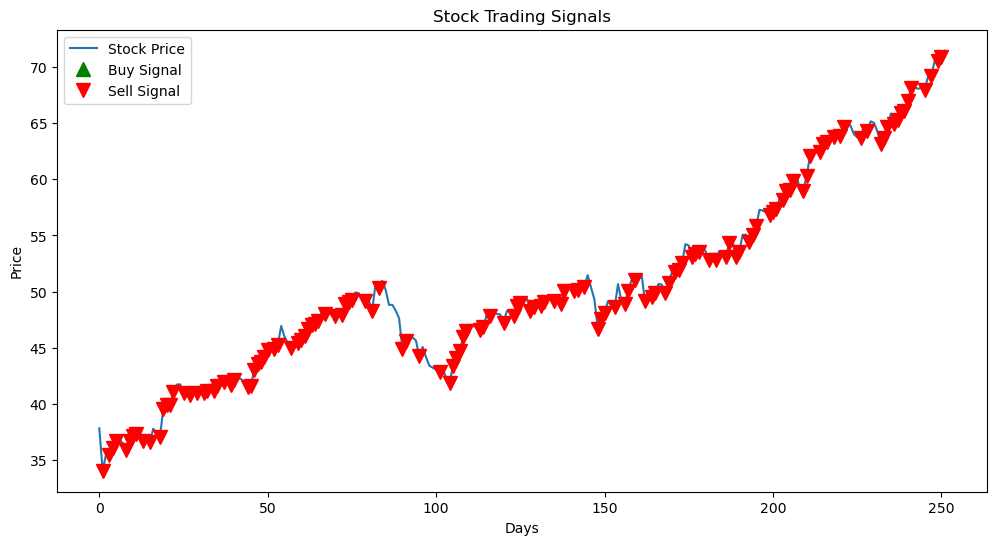

In [27]:
plot_trading_strategy(prices, actions)